# Binary Classification
Prediction of average sentiment of an event given only the source URL for respective events in the GDELT dataset. The project uses dask for data preprocessing + storage. Navigate to http://127.0.0.1:8787 to view the dashboard.

In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client

from dask.diagnostics import ProgressBar

from url_parser import parse_url

client = Client()

In [2]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 125.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42343,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 125.60 GiB
Comm: tcp://127.0.0.1:37797,Total threads: 4
Dashboard: http://127.0.0.1:45253/status,Memory: 20.93 GiB
Nanny: tcp://127.0.0.1:34807,


In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

pbar = ProgressBar()
pbar.register()
# GDELT CodeBook: http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf

In [4]:
# Load the US -> China and China -> US events only
dat = dd.read_parquet("data/output")
only_us = dat[(dat.Actor1Code == "USA") & (dat.Actor2Code == "CHN")]
only_china = dat[(dat.Actor1Code == "CHN") & (dat.Actor2Code == "USA")]
dat.head()

,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,Actor1Religion2Code,Actor1Type1Code,Actor1Type2Code,Actor1Type3Code,Actor2Code,Actor2Name,Actor2CountryCode,Actor2KnownGroupCode,Actor2EthnicCode,Actor2Religion1Code,Actor2Religion2Code,Actor2Type1Code,Actor2Type2Code,Actor2Type3Code,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Type,Actor1Geo_FullName,Actor1Geo_CountryCode,Actor1Geo_ADM1Code,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_FeatureID,Actor2Geo_Type,Actor2Geo_FullName,Actor2Geo_CountryCode,Actor2Geo_ADM1Code,Actor2Geo_Lat,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
GLOBALEVENTID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
963548206,20201211,202012,2020,2020.9342,USAEDU,UNITED STATES,USA,None,None,None,None,EDU,None,None,EDU,SCHOOL,None,None,None,None,None,EDU,None,None,0,030,030,03,1,4.0,2,1,2,1.01522842639594,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,20210110,https://www.ktvb.com/article/news/health/coron...
963548207,20210103,202101,2021,2021.0082,None,None,None,None,None,None,None,None,None,None,MIL,NATIONAL GUARD,None,None,None,None,None,MIL,None,None,1,036,036,03,1,4.0,70,5,70,-4.75240042017015,0,None,None,None,None,None,None,2,"California, United States",US,USCA,36.17,-119.746,CA,2,"California, United States",US,USCA,36.17,-119.746,CA,20210110,https://www.mdjonline.com/tribune/lifestyles/a...
963548213,20210103,202101,2021,2021.0082,USA,UNITED STATES,USA,None,None,None,None,None,None,None,GOV,SECRETARY OF STATE,None,None,None,None,None,GOV,None,None,0,020,020,02,1,3.0,142,38,142,-4.17371166647743,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,20210110,https://accesswdun.com/article/2021/1/969753
963548214,20210103,202101,2021,2021.0082,USA,OREGON,USA,None,None,None,None,None,None,None,USAMIL,OREGON,USA,None,None,None,None,MIL,None,None,1,080,080,08,2,5.0,6,1,6,1.01522842639594,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,20210110,https://www.ktvb.com/article/news/health/coron...
963548215,20210103,202101,2021,2021.0082,USA,UNITED STATES,USA,None,None,None,None,None,None,None,USAMIL,UNITED STATES,USA,None,None,None,None,MIL,None,None,1,080,080,08,2,5.0,4,1,4,1.01522842639594,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,20210110,https://www.ktvb.com/article/news/health/coron...


In [5]:
topn = 100
urls = only_china[["SOURCEURL", "AvgTone"]].compute()
urls = urls.dropna()
print(urls)

                                                       SOURCEURL  \
GLOBALEVENTID                                                      
963548586      https://www.cantonrep.com/story/tech/2021/01/0...   
963550411      http://www.msn.com/en-nz/news/world/pompeo-lif...   
963550412      http://www.msn.com/en-nz/news/world/pompeo-lif...   
963550413      https://www.zerohedge.com/geopolitical/washing...   
963550414      https://www.rnz.co.nz/news/world/434296/pompeo...   
...                                                          ...   
972870556      https://thestandard.org.nz/biden-can-reset-wit...   
972870557      https://www.bangkokpost.com/opinion/opinion/20...   
972870558      https://www.bangkokpost.com/opinion/opinion/20...   
972872413      https://www.azcentral.com/story/news/local/ari...   
972872414      https://www.azcentral.com/story/news/local/ari...   

                         AvgTone  
GLOBALEVENTID                     
963548586      -5.23353967360721  
963550411 

### URL Preprocessing
We take new URLs, which often embed key words about the events discussed in the actual articles, and create a TfIDF vector out of them. The hypothesis is that we should be able to train a much more efficient "distilled" classifier for sentiment by training and inferencing on just the URLs, rather than the entire story.

To clean the URL, we remove numbers, separate based on '/' or '-' characters, which are often used to represent spaces in URL strings. To create the binary Ys, we use a ternary operator to convert float tone variables into 0 or 1 values.

While the count normalization step (which limits the number of items in each class to the number of elements in the smallest class by order presedence) is unnecessary (so long as we weigh the accuracy metrics properly), we performed count normalization to make the confusion matrix pretty.

In [6]:
import re
import string
from urllib.parse import urlparse
from collections import Counter
import numpy as np

def clean_url(inp_url:str) -> str:
    url = urlparse(inp_url)
    translation_table = str.maketrans("", "", string.digits)
    return (re.sub(' +', ' ', url.path
                .replace(".html", "")
                .replace("/", " ")
                .replace("-", " ")
                .translate(translation_table)
                .strip()))
    
from tqdm import tqdm

print(len(urls))
cleaned_urls = urls["SOURCEURL"].apply(clean_url)
sentiment = np.array([1 if float(n) >= 0 else 0 for n in urls["AvgTone"].tolist()]).astype(int)
min_key, min_count = min(Counter(sentiment).items(), key=lambda x: x[1])
num_added = {x:0 for x in range(0, 2)}

count_norm_x = []
count_norm_y = []
for url, qc in zip(cleaned_urls, sentiment):
    if num_added[qc] <= min_count:
        count_norm_x.append(url)
        count_norm_y.append(qc)
        num_added[qc] += 1
        
print(len(count_norm_x), len(count_norm_y))
print(Counter(count_norm_y))

121585
48837 48837
Counter({0: 24419, 1: 24418})


In [7]:
from dask_ml.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [8]:
vectorizer = TfidfVectorizer(max_features=2**15)
X = vectorizer.fit_transform(count_norm_x)
X.shape

(48837, 26584)

In [13]:
# PCA is not available here because the output from TfidfVectorizer is a sparse matrix, rather than dense
# TruncatedSVD can deal with sparse input matrices
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=4096)
x_reduced = pca.fit_transform(X)
x_reduced.shape

(48837, 4096)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_reduced, count_norm_y, test_size=0.2)

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix,
                            ConfusionMatrixDisplay,
                            precision_score,
                            recall_score,
                            accuracy_score,
                            f1_score)


def evaluate_model(y_preds, y_true):
    """
    Generates a confusion matrix and calculates f1 scores,
    accuracy measures, recall and precision given predicted Ys
    and ground truth Ys.
    """
    conf = confusion_matrix(y_test, y_preds)
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    display = ConfusionMatrixDisplay(conf)
    display.plot(ax=ax)
    
    print("All applicable scores are weighted")
    print(f"F1 Score : {f1_score(y_true, y_preds, average='weighted')}")
    print(f"Accuracy : {accuracy_score(y_true, y_preds)}")
    print(f"Recall   : {recall_score(y_true, y_preds, average='weighted')}")
    print(f"Precision: {precision_score(y_true, y_preds, average='weighted')}")

## Binary Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(verbose=True, max_iter=10000, n_jobs=20)
reg.fit(x_train, y_train)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         4097     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70806D+04    |proj g|=  2.31476D+02


 This problem is unconstrained.



At iterate   50    f=  1.89313D+04    |proj g|=  6.02471D+01

At iterate  100    f=  1.89085D+04    |proj g|=  2.63191D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 4097    106    122      1     0     0   4.939D-01   1.891D+04
  F =   18908.467116085896     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   12.4s finished


LogisticRegression(max_iter=10000, n_jobs=20, verbose=True)

All applicable scores are weighted
F1 Score : 0.8055144780032318
Accuracy : 0.8056920556920557
Recall   : 0.8056920556920557
Precision: 0.8063619108558027


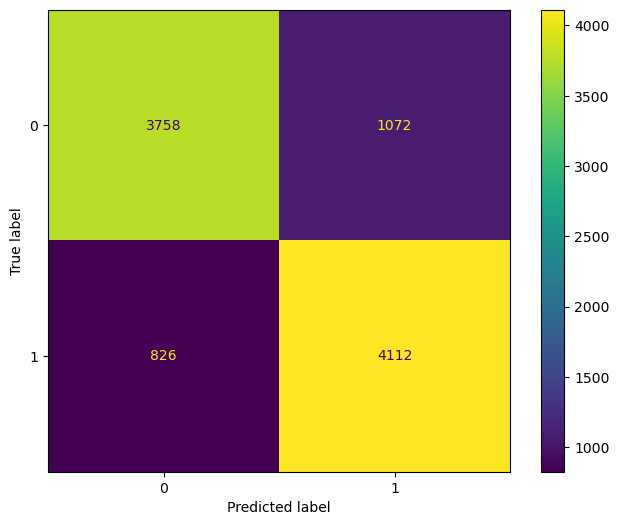

In [18]:
y_preds = reg.predict(x_test)
evaluate_model(y_preds, y_test)

## Linear Support Vector Classifier

Note that this next section requires at least 100GB of RAM or enough SWAP to account for lack of RAM. If your machine has less, please change the `n_jobs` parameter so that instances of Linear SVMs are not created in parallel.

Took about 30 minutes to run on my i9-12900K. with 20 Cores.

In [25]:
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

pipe = Pipeline([('classifier', LinearSVC(random_state=42, dual=False))])
param_grid = {
    "classifier__penalty": ["l1", "l2"],
    "classifier__loss": ["squared_hinge", "hinge"],
    "classifier__C": [1.0, 1.25, 1.5, 1.7, 2.0, 2.5]
}

clf = GridSearchCV(pipe,
                  param_grid=param_grid,
                  cv=5, n_jobs=20, verbose=True)
clf.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        LinearSVC(dual=False,
                                                  random_state=42))]),
             n_jobs=20,
             param_grid={'classifier__C': [1.0, 1.25, 1.5, 1.7, 2.0, 2.5],
                         'classifier__loss': ['squared_hinge', 'hinge'],
                         'classifier__penalty': ['l1', 'l2']},
             verbose=True)

0.799380482955976
{'classifier__C': 2.0, 'classifier__loss': 'squared_hinge', 'classifier__penalty': 'l2'}

All applicable scores are weighted
F1 Score : 0.8130736975230034
Accuracy : 0.8131654381654382
Recall   : 0.8131654381654382
Precision: 0.8134695613755616


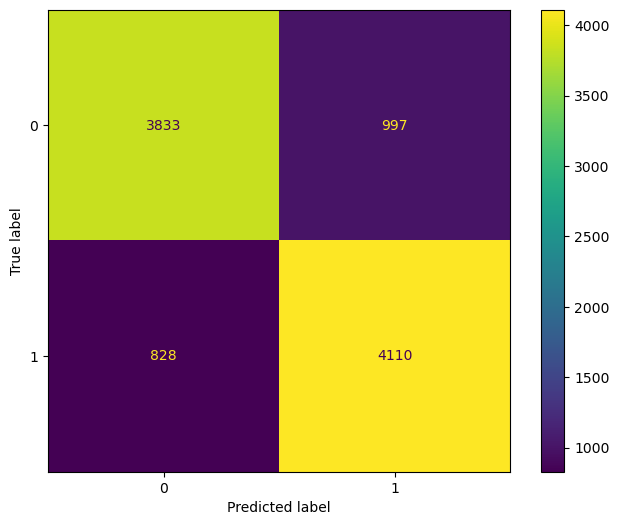

In [26]:
print(clf.best_score_)
print(clf.best_params_)
print()

y_preds = clf.predict(x_test)
evaluate_model(y_preds, y_test)

## Perceptron Binary Classification

In [ ]:
from sklearn.linear_model import Perceptron
clf = Perceptron(tol=None, 
                 random_state=42, 
                 verbose=1, 
                 max_iter=1000)
clf = clf.fit(x_train, y_train)

In [28]:
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

0.6195705034682228
0.6087223587223587


All applicable scores are weighted
F1 Score : 0.5456176994120415
Accuracy : 0.6087223587223587
Recall   : 0.6087223587223587
Precision: 0.7574332225462863


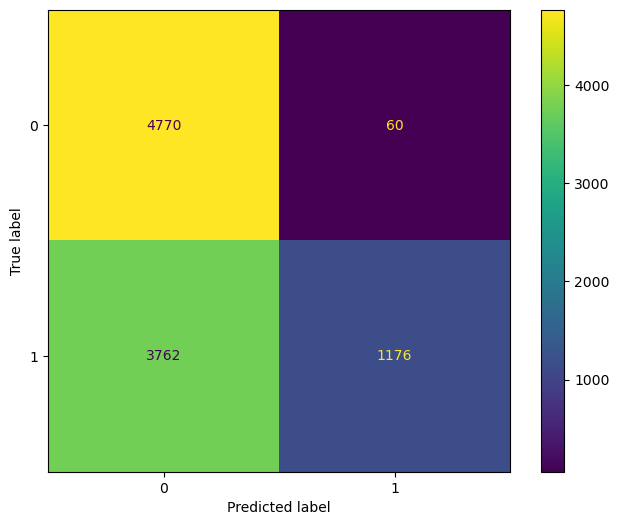

In [29]:
y_preds = clf.predict(x_test)
evaluate_model(y_preds, y_test)